In [1]:
import gc
gc.collect()

61

In [18]:
import pandas as pd
import numpy as np
from numpy.random import seed
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow import keras as k
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler(feature_range=(0, 1))

In [3]:
data_pickle = pd.read_pickle('./model_data.pickle')
data_pickle = data_pickle.dropna()
data_pickle.head()

# Check the highest length of text and title:
max_tokens_text = 13000
max_tokens_title = 48

In [4]:
#Train - test
X_train, X_test, y_train, y_test = train_test_split(
    data_pickle[['text', 'title','anger','anticipation','disgust','fear','joy','sadness','surprise','trust','negative','positive']], data_pickle['type'], test_size=0.2, random_state=42)

#Train - valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

In [5]:
dftrain = X_train.iloc[:,2:]
MaxMin_df_train = scaler.fit_transform(dftrain)

dftest = X_test.iloc[:,2:]
MaxMin_df_test = scaler.fit_transform(dftest)

dfvalid = X_valid.iloc[:,2:]
MaxMin_df_valid = scaler.fit_transform(dfvalid)

In [6]:
train_fit = [np.asarray(X_train['title'].tolist()), 
             np.asarray(X_train['text'].tolist()),
            MaxMin_df_train
            ]

test_fit = [np.asarray(X_test['title'].tolist()), 
             np.asarray(X_test['text'].tolist()),
            MaxMin_df_test
            ]    

valid_fit = [np.asarray(X_valid['title'].tolist()), 
             np.asarray(X_valid['text'].tolist()),
            MaxMin_df_valid
            ]


## LSTM

In [9]:
seed(50)
tf.random.set_seed(50)
k.backend.clear_session()

In [10]:
#input_title
title_input = k.layers.Input(shape=(max_tokens_title,))
inp = k.layers.Embedding(input_dim=3000000,output_dim=300,trainable=False)(title_input)
x1 = k.layers.Bidirectional(k.layers.LSTM(50))(inp)


#input_Text
content_input = k.layers.Input(shape=(max_tokens_text,))
inp2 = k.layers.Embedding(input_dim=3000000,output_dim=300,trainable=False)(content_input)
x2 = k.layers.Bidirectional(k.layers.LSTM(200))(inp2)

#input_sentiments
x3 = k.layers.Input(shape=(10,))


#Merge
# x = k.layers.concatenate([x1, x2])
x = k.layers.concatenate([x1, x2, x3])


#Common part
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)

out = k.layers.Dense(1, activation='sigmoid')(x)

#Build model
# baseline_model = k.models.Model(inputs=[title_input, content_input], outputs=[out])
baseline_model = k.models.Model(inputs=[title_input, content_input,x3], outputs=[out])
baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

baseline_model.summary()

2022-05-27 10:50:01.335108: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-27 10:50:01.335143: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-27 10:50:01.335167: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (frontend01): /proc/driver/nvidia/version does not exist
2022-05-27 10:50:01.336543: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 13000)]      0           []                               
                                                                                                  
 embedding (Embedding)          (None, 48, 300)      900000000   ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 13000, 300)   900000000   ['input_2[0][0]']                
                                                                                              

In [12]:
history = baseline_model.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size = 64,
        callbacks = [k.callbacks.EarlyStopping(monitor='val_loss', patience=1,min_delta = 0.1)], 
                            validation_data=(valid_fit, np.array(y_valid.tolist())), epochs = 3)

Epoch 1/3
197/197 [==============================] - 4406s 22s/step - loss: 0.5033 - acc: 0.7481 - val_loss: 0.3561 - val_acc: 0.8323
Epoch 2/3
197/197 [==============================] - 4387s 22s/step - loss: 0.2885 - acc: 0.8770 - val_loss: 0.2816 - val_acc: 0.8796


In [13]:
test_pred = baseline_model.predict(test_fit)
report = classification_report(np.array(y_test.tolist()), test_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2354
           1       0.93      0.79      0.85      1581

    accuracy                           0.89      3935
   macro avg       0.90      0.88      0.88      3935
weighted avg       0.90      0.89      0.89      3935



In [14]:
print("The accuracy for testing data is", np.mean(test_pred.round() == np.array(y_test.tolist())))

The accuracy for testing data is 0.5310763050782329


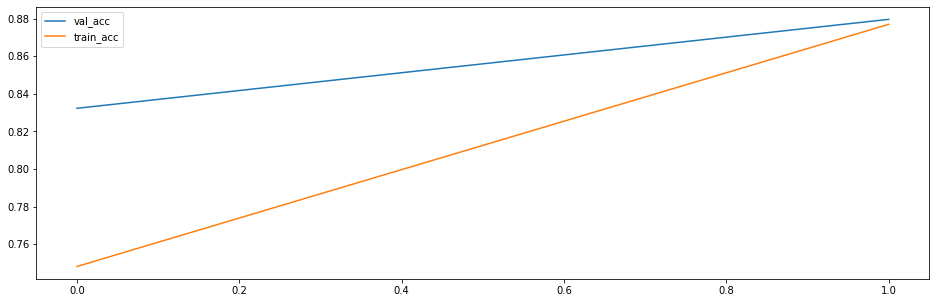

In [15]:
plt.figure(figsize=(16,5))
plt.plot(history.history['val_acc'], label='val_acc')
plt.plot(history.history['acc'], label='train_acc')
plt.legend()

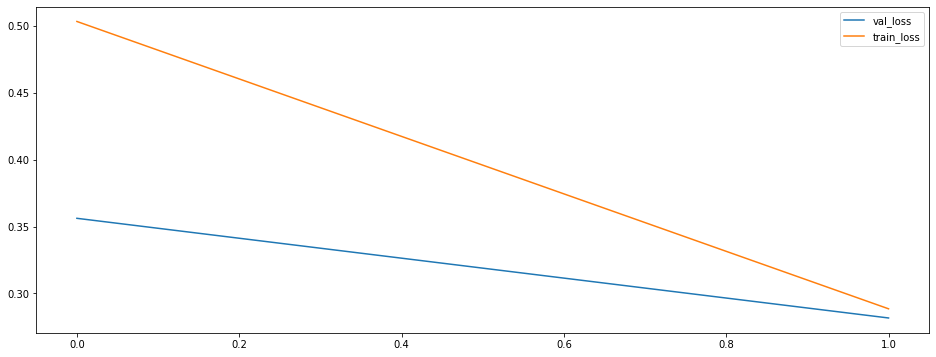

In [16]:
plt.figure(figsize=(16,6))
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='train_loss')
plt.legend()

[[2259   95]
 [ 331 1250]]


<AxesSubplot:>

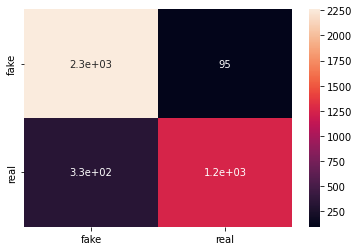

In [19]:
matrix = confusion_matrix(np.array(y_test.tolist()), test_pred.round())
print(matrix)

df_cm = pd.DataFrame(matrix, columns=['fake', 'real'], index=['fake', 'real'])
sns.heatmap(df_cm, annot=True)

## CNN

In [20]:
seed(50)
tf.random.set_seed(50)
k.backend.clear_session()

In [21]:
#input_title
title_input = k.layers.Input(shape=(max_tokens_title,))
inp1 = k.layers.Embedding(input_dim=3000000,output_dim=300,trainable=False)(title_input)

x1 = k.layers.Conv1D(filters = 32, kernel_size=2, strides=2, activation='relu')(inp1)
x1 = k.layers.MaxPool1D(pool_size = 2)(x1)
x1 = k.layers.Flatten()(x1)
x1 = k.layers.Dense(50, activation='relu', kernel_regularizer='l2')(x1)


#input_Text
text_input = k.layers.Input(shape=(max_tokens_text,))
inp2 = k.layers.Embedding(input_dim=3000000,output_dim=300,trainable=False)(text_input)


x2 = k.layers.Conv1D(filters = 64, kernel_size = 4, strides = 2, activation='relu')(inp2)
x2 = k.layers.MaxPool1D(pool_size = 4)(x2)


x2 = k.layers.Flatten()(x2)
x2 = k.layers.Dense(100, activation='relu', kernel_regularizer='l2')(x2)


#Sentiments-------------------------------------------------------------------------------------------------------

sentiment_input = k.layers.Input(shape=(10,))
x3 = k.layers.Flatten()(sentiment_input)
x3= k.layers.Dense(10, activation='relu', kernel_regularizer='l2')(x3)

#Merge-------------------------------------------------------------------------------------------------------------
# x = k.layers.concatenate([x1,x2])
x = k.layers.concatenate([x1,x2,x3])
x = k.layers.Dropout(0.2)(x)

#Common part-------------------------------------------------------------------------------------------------------
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
out = k.layers.Dense(1, activation='sigmoid')(x)


#Build model
# model1 = k.models.Model(inputs=[title_input, text_input], outputs=[out])
model1 = k.models.Model(inputs=[title_input, text_input,sentiment_input], outputs=[out])

model1.compile(k.optimizers.RMSprop(), loss='binary_crossentropy', metrics=['acc'])
# model1.compile(loss='categorical_crossentropy',
#               optimizer=sgd,
#               metrics=['acc'])

model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 13000)]      0           []                               
                                                                                                  
 embedding (Embedding)          (None, 48, 300)      900000000   ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 13000, 300)   900000000   ['input_2[0][0]']                
                                                                                              

## Fitting the model

In [22]:
%%time
history = model1.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size=64, epochs=30,
        callbacks = [k.callbacks.EarlyStopping(monitor='val_loss', patience=3,min_delta = 0.1)], 
        validation_data=(valid_fit, np.array(y_valid.tolist()))
        )

Epoch 1/30
197/197 [==============================] - 225s 1s/step - loss: 0.8137 - acc: 0.7358 - val_loss: 0.5044 - val_acc: 0.8351
Epoch 2/30
197/197 [==============================] - 221s 1s/step - loss: 0.4537 - acc: 0.8601 - val_loss: 0.4143 - val_acc: 0.8774
Epoch 3/30
197/197 [==============================] - 219s 1s/step - loss: 0.3624 - acc: 0.8976 - val_loss: 0.3346 - val_acc: 0.9082
Epoch 4/30
197/197 [==============================] - 219s 1s/step - loss: 0.2915 - acc: 0.9295 - val_loss: 0.2788 - val_acc: 0.9298
Epoch 5/30
197/197 [==============================] - 219s 1s/step - loss: 0.2403 - acc: 0.9507 - val_loss: 0.2583 - val_acc: 0.9374
Epoch 6/30
197/197 [==============================] - 220s 1s/step - loss: 0.2027 - acc: 0.9649 - val_loss: 0.2714 - val_acc: 0.9358
CPU times: user 4h 14min 26s, sys: 1h 11min 1s, total: 5h 25min 27s
Wall time: 22min 3s


## Results

In [23]:
test_pred = model1.predict(test_fit)
report = classification_report(np.array(y_test.tolist()), test_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      2354
           1       0.96      0.89      0.92      1581

    accuracy                           0.94      3935
   macro avg       0.94      0.93      0.94      3935
weighted avg       0.94      0.94      0.94      3935



In [24]:
print("The accuracy for testing data is", np.mean(test_pred.round() == np.array(y_test.tolist())))

The accuracy for testing data is 0.5245365525236168


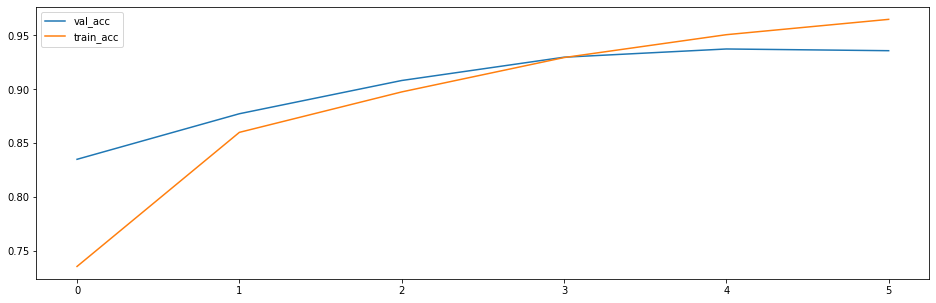

In [25]:
plt.figure(figsize=(16,5))
plt.plot(history.history['val_acc'], label='val_acc')
plt.plot(history.history['acc'], label='train_acc')
plt.legend()

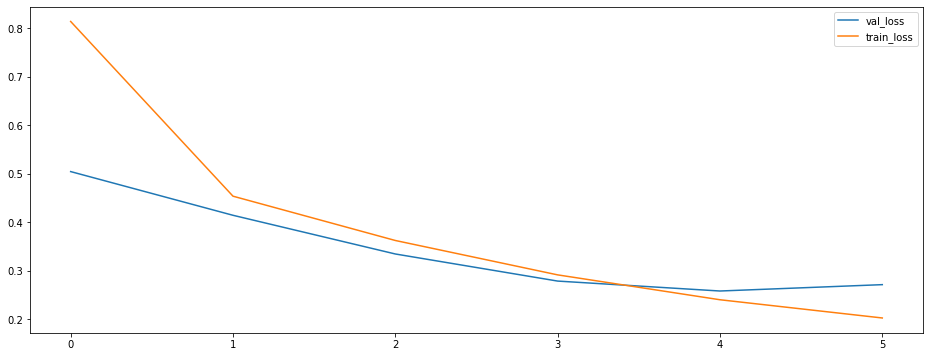

In [26]:
plt.figure(figsize=(16,6))
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='train_loss')
plt.legend()

[[2289   65]
 [ 170 1411]]


<AxesSubplot:>

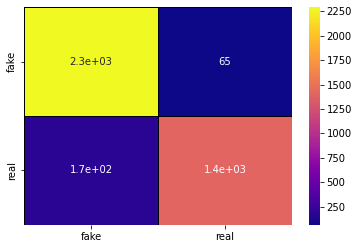

In [27]:
matrix = confusion_matrix(np.array(y_test.tolist()), test_pred.round())
print(matrix)

df_cm = pd.DataFrame(matrix, columns=['fake', 'real'], index=['fake', 'real'])
sns.heatmap(df_cm, annot=True,cmap ='plasma', linecolor ='black', linewidths = 1)

## Cross_entrophy CNN

In [28]:
# seed(50)
# tf.random.set_seed(50)
# k.backend.clear_session()

In [ ]:
# #input_title
# title_input = k.layers.Input(shape=(max_tokens_title,))
# inp1 = k.layers.Embedding(input_dim=3000000,output_dim=300,trainable=False)(title_input)

# x1 = k.layers.Conv1D(filters = 32, kernel_size=4, strides=2, activation='relu')(inp1)
# x1 = k.layers.MaxPool1D(pool_size = 2)(x1)
# x1 = k.layers.Flatten()(x1)
# x1 = k.layers.Dense(50, activation='relu',  kernel_regularizer='l2')(x1)

# #input_content
# text_input = k.layers.Input(shape=(max_tokens_text,))
# inp2 = k.layers.Embedding(input_dim=3000000,output_dim=300,trainable=False)(text_input)

# x2 = k.layers.Conv1D(filters = 64, kernel_size = 4, strides = 2, activation='relu')(inp2)
# x2 = k.layers.MaxPool1D(pool_size = 4 )(x2)

# #Added
# # x2 = k.layers.Conv1D(filters = 80, kernel_size = 16, strides = 4, activation='relu')(inp2)
# # x2 = k.layers.MaxPool1D(pool_size = 4, )(x2)
# x2 = k.layers.Flatten()(x2)
# x2 = k.layers.Dense(100, activation='relu', kernel_regularizer='l2')(x2)

# sentiment_input = k.layers.Input(shape=(10,))
# x3 = k.layers.Flatten()(sentiment_input)
# x3= k.layers.Dense(10, activation='relu', kernel_regularizer='l2')(x3)


# #Merge
# # x = k.layers.concatenate([x1, x2])
# x = k.layers.concatenate([x1,x2,x3])
# x = k.layers.Dropout(0.2)(x)

# #Common part
# # x = k.layers.Dense(50, activation='relu')(x)
# # x = k.layers.Dropout(0.2)(x)
# x = k.layers.Dense(50, activation='relu')(x)
# x = k.layers.Dropout(0.2)(x)
# out = k.layers.Dense(5, activation='softmax')(x)


# #Build model
# # model = k.models.Model(inputs=[title_input, text_input], outputs=[out])
# model2 = k.models.Model(inputs=[title_input, text_input,sentiment_input], outputs=[out])
# model2.compile(k.optimizers.RMSprop(), loss='sparse_categorical_crossentropy', metrics=['acc'])

# model2.summary()

## Fitting the model

In [ ]:
# history = model2.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size=128, epochs=30,
#         callbacks = [k.callbacks.EarlyStopping(monitor='val_loss', patience=3,min_delta = 0.1)], 
#         validation_data=(valid_fit, np.array(y_valid.tolist())))

In [ ]:
# test_pred = model2.predict(test_fit)

# #get predicted indices (ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets)
# test_pred = np.argmax(test_pred, 1)

# report = classification_report(np.array(y_test.tolist()), test_pred.round())
# print(report)

In [ ]:
# print("The accuracy for testing data is", np.mean(test_pred.round() == np.array(y_test.tolist())) )
# print("The accuracy for training data is", np.mean(np.argmax(model2.predict(train_fit),1) == np.array(y_train.tolist())) )

In [ ]:
# matrix = confusion_matrix(np.array(y_test.tolist()), test_pred.round())
# print(matrix)

# df_cm = pd.DataFrame(matrix, columns=['fake', 'real'], index=['fake', 'real'])
# sns.heatmap(df_cm, annot=True,cmap ='plasma', linecolor ='black', linewidths = 1)